## Modelling and evaluation

### Addressing the business question no. 2:
* Can we tell if an uploaded (previously unseen) image was taken for a 'Healthy', 'Bleached' or 'Dead' coral.

### Inputs

* inputs/corals-dataset/Healthy
* inputs/corals-dataset/Bleached
* inputs/corals-dataset/Dead
* outputs/v1/image_shape.pkl

### Outputs

* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.

### Import packages

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

### Define working directory

In [3]:
cwd = os.getcwd()
os.chdir('/workspace/corals_health')
print("You set a new current directory")
work_dir = os.getcwd()
work_dir

You set a new current directory


'/workspace/corals_health'

### Set input directories

In [4]:
my_data_dir = 'inputs/corals-dataset/Dataset'
train_path = os.path.join(my_data_dir, 'train')
val_path = os.path.join(my_data_dir, 'validation')
test_path = os.path.join(my_data_dir, 'test')
print(train_path)
print(val_path)
print(test_path)

inputs/corals-dataset/Dataset/train
inputs/corals-dataset/Dataset/validation
inputs/corals-dataset/Dataset/test


### Set output directories

In [5]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


### Set labels

In [6]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)
print(type(labels))

Project Labels: ['Bleached', 'Dead', 'Healthy']
<class 'list'>


### Set image shape

In [7]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(227, 227, 3)

### Number of images in train, test and validation data

* train - Bleached: 503 images
* train - Dead: 105 images
* train - Healthy: 496 images
* validation - Bleached: 72 images
* validation - Dead: 15 images
* validation - Healthy: 71 images
* test - Bleached: 145 images
* test - Dead: 30 images
* test - Healthy: 143 images




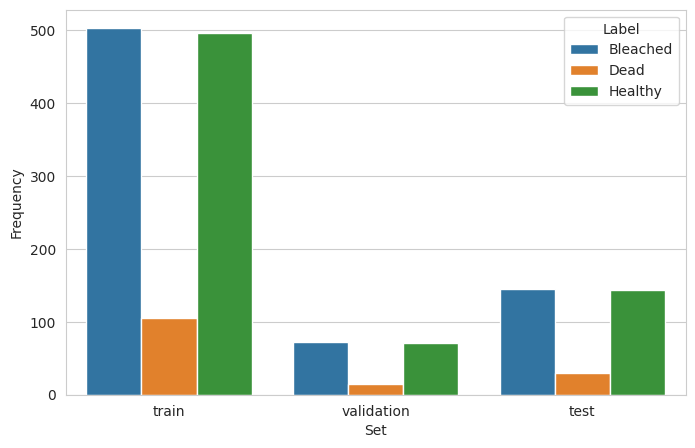

In [8]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Data augmentation

### ImageDataGenerator

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

* Initialize ImageDataGenerator

In [10]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

* Augment training dataset

In [11]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 1104 images belonging to 3 classes.


{'Bleached': 0, 'Dead': 1, 'Healthy': 2}

* Augment validation dataset

In [12]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 158 images belonging to 3 classes.


{'Bleached': 0, 'Dead': 1, 'Healthy': 2}

* Aurment test dataset

In [13]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 318 images belonging to 3 classes.


{'Bleached': 0, 'Dead': 1, 'Healthy': 2}

#### Plot augmented training image

(20, 227, 227, 3)


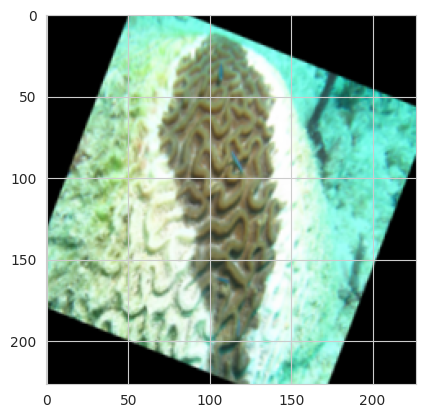

(20, 227, 227, 3)


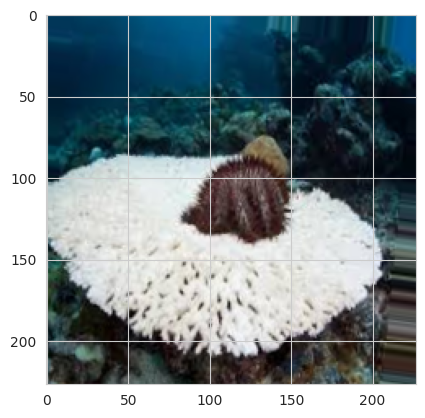

(20, 227, 227, 3)


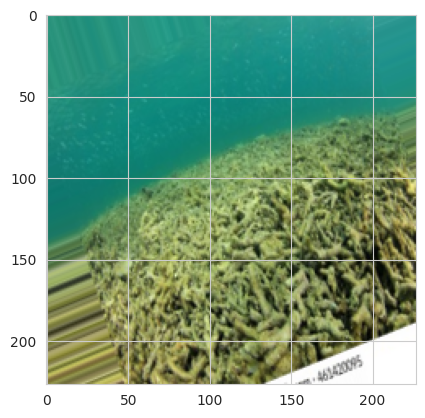

In [14]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

#### Plot augmented validation image

(20, 227, 227, 3)


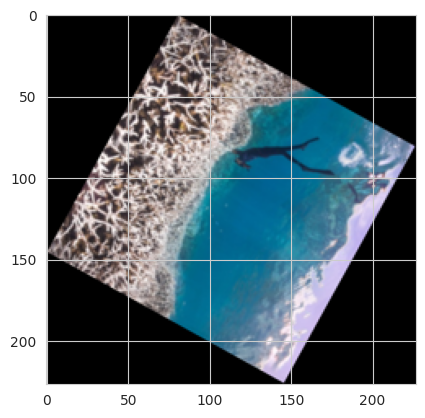

(20, 227, 227, 3)


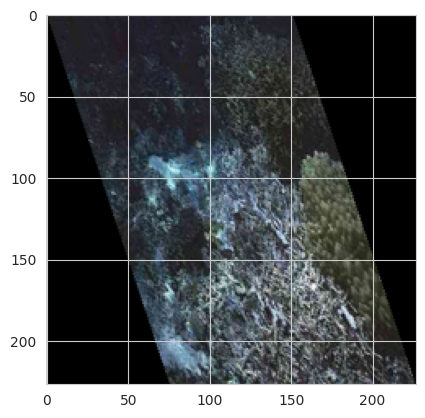

(20, 227, 227, 3)


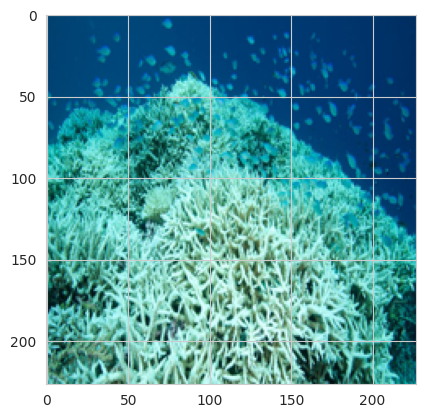

In [15]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

#### Plot augmented test image

(20, 227, 227, 3)


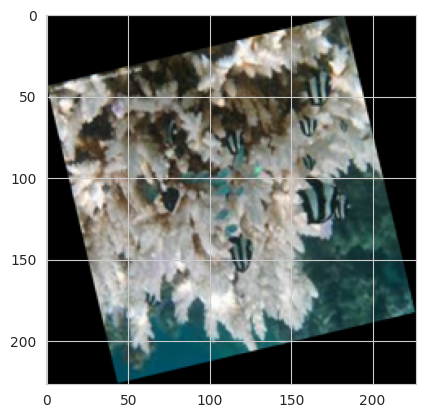

(20, 227, 227, 3)


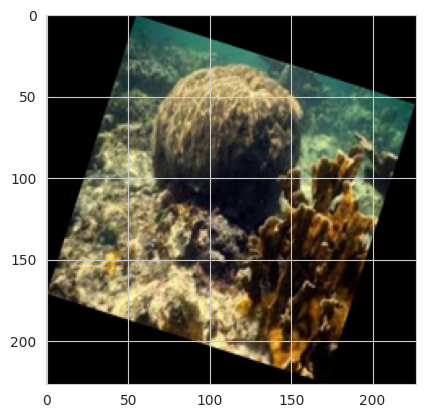

(20, 227, 227, 3)


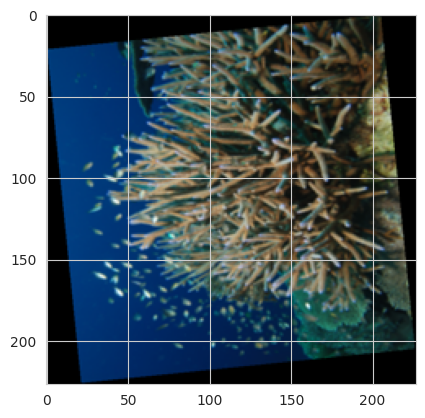

In [16]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

### Save class_indices

In [28]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

<hr>


## Building the model
<hr>

### Import model packages

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


#### Model

In [30]:
def create_tf_model():
    """
    Function that will create, compile and return a sequential model for classifying
    three types of images of corals ('healthy', 'bleached' and 'dead')
    """
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

#### Model summary

In [31]:
image_shape = (227, 227, 3)
create_tf_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 225, 225, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 53, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0

2024-08-15 20:21:06.869716: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Define early stop

In [45]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

### Fit model for model training

In [40]:
train_set.classes

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [46]:
model = create_tf_model()

In [47]:
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/25


55/55 [==============================] - 59s 1s/step - loss: 0.8080 - accuracy: 0.6642 - val_loss: 0.5545 - val_accuracy: 0.7975
Epoch 2/25
55/55 [==============================] - 56s 1s/step - loss: 0.5399 - accuracy: 0.8054 - val_loss: 0.4844 - val_accuracy: 0.8228
Epoch 3/25
55/55 [==============================] - 56s 1s/step - loss: 0.5189 - accuracy: 0.8100 - val_loss: 0.4324 - val_accuracy: 0.8228
Epoch 4/25
55/55 [==============================] - 56s 1s/step - loss: 0.4363 - accuracy: 0.8469 - val_loss: 0.4032 - val_accuracy: 0.8608
Epoch 5/25
55/55 [==============================] - 57s 1s/step - loss: 0.4131 - accuracy: 0.8496 - val_loss: 0.3589 - val_accuracy: 0.8734
Epoch 6/25
55/55 [==============================] - 65s 1s/step - loss: 0.4507 - accuracy: 0.8395 - val_loss: 0.3618 - val_accuracy: 0.8734
Epoch 7/25
55/55 [==============================] - 58s 1s/step - loss: 0.3827 - accuracy: 0.8524 - val_loss: 0.3593 - val_accuracy: 0.8671
Epoch 8/25
55/55 [=============

In [48]:
model.save('outputs/v1/corals_health_model_1.h5')

<hr>

## Model performance<hr>

### Model learning curve

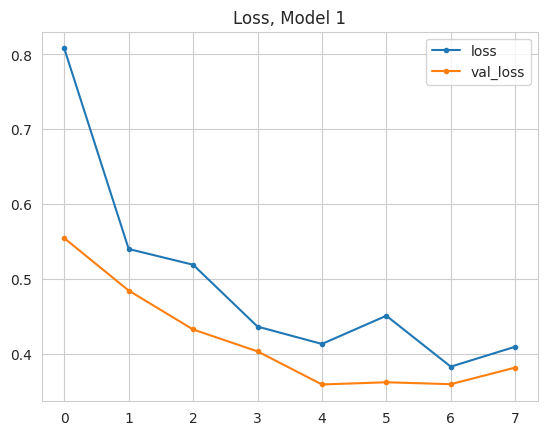

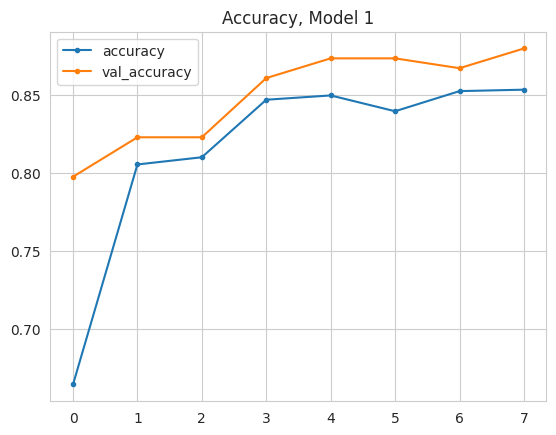

In [49]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss, Model 1")
plt.savefig(f'{file_path}/model_1_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy, Model 1")
plt.savefig(f'{file_path}/model_1_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

### Model evaluation

#### Load model

In [50]:
from keras.models import load_model
model = load_model('outputs/v1/corals_health_model_1.h5')

#### Evaluate model on the test set

In [51]:
evaluation = model.evaluate(test_set)

16/16 [==============================] - 8s 480ms/step - loss: 0.4399 - accuracy: 0.8365


#### Save evaluation pickle

In [80]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

### Prediction on new data

#### Load random image as PIL

['Bleached', 'Dead', 'Healthy']
Image shape: (227, 227), Image mode: RGB


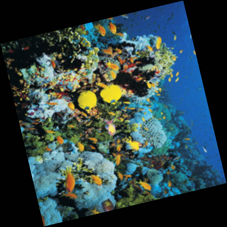

In [81]:
from tensorflow.keras.preprocessing import image

pointer = 4
label = labels[2] # 'Bleached', 'Dead', 'Healthy''.
print(labels)

pil_image = image.load_img(os.path.join(test_path, label, os.listdir(test_path+'/' + label)[pointer]), target_size=image_shape, color_mode='rgb')

#test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer], target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

#### Convert image to array and prepare for prediction

In [82]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 227, 227, 3)


#### Predict class probabilities

In [83]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

0.997964788461104
Bleached
